Цель работы - анализ предложений по аренде квартир в двух районах Москвы.
Были выбраны два района - Академический и Выхино-Жулебино. В качестве источника данных использовался сайт cian.ru
Для данных о годе постройки дома использовалиьс данные с сайта
Был написан парсер для получения данныз с сайта циан

In [ ]:
import requests
import time
from bs4 import BeautifulSoup

BASE_URL = "https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&in_polygon%5B1%5D=37.787165_55.675748%2C37.787165_55.721493%2C37.864834_55.721493%2C37.864834_55.675748%2C37.787165_55.675748&offer_type=flat&p={page}&polygon_name%5B1%5D=район+Выхино-Жулебино&type=4"
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    )
}
output_file = "cian_flats.html"
with open(output_file, "w", encoding="utf-8") as f:
    for page in range(1, 8):
        url = BASE_URL.format(page=page)
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")
        divs = soup.find_all("div", {"data-name": "LinkArea"})
        for div in divs:
            f.write(div.prettify())
            f.write("\n\n")
        sleep_time = 3 + (page % 3)
        time.sleep(sleep_time)
print("Ok")



Полученные данные в формате html были обработаны и переведены в табличный формат


In [ ]:
from bs4 import BeautifulSoup
import csv
import re
import sqlite3
import json
from datetime import datetime

def parse_cian_flats(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    flats = []
    flat_containers = soup.find_all('div', class_='_93444fe79c--container--kZeLu _93444fe79c--link--DqDOy')
    for container in flat_containers:
        try:
            title_elem = container.find('span', {'data-mark': 'OfferTitle'})
            title_text = title_elem.get_text(strip=True) if title_elem else ""
            subtitle_elem = container.find('span', {'data-mark': 'OfferSubtitle'})
            subtitle_text = subtitle_elem.get_text(strip=True) if subtitle_elem else ""
            if not has_technical_info(title_text) and subtitle_text:
                parse_text = subtitle_text
            else:
                parse_text = title_text
            rooms, area, current_floor, total_floors = parse_technical_info(parse_text)
            metro_info = container.find('div', class_='_93444fe79c--container--w7txv')
            metro_name = "Не указано"
            metro_distance = "Не указано"
            if metro_info:
                metro_div = metro_info.find('div', string=re.compile(r'[А-Яа-я]'))
                if metro_div:
                    metro_name = metro_div.get_text(strip=True)
                distance_div = metro_info.find('div', class_='_93444fe79c--remoteness--q8IXp')
                if distance_div:
                    metro_distance = distance_div.get_text(strip=True)
            address_labels = container.find('div', class_='_93444fe79c--labels--L8WyJ')
            address = "Не указан"
            if address_labels:
                address_parts = [a.get_text(strip=True) for a in address_labels.find_all('a')]
                address = ', '.join(address_parts)
            price_elem = container.find('span', {'data-mark': 'MainPrice'})
            price = price_elem.get_text(strip=True) if price_elem else "Не указана"
            price_info_elem = container.find('p', {'data-mark': 'PriceInfo'})
            price_info = price_info_elem.get_text(strip=True) if price_info_elem else ""
            description_elem = container.find('div', {'data-name': 'Description'})
            description = description_elem.get_text(strip=True) if description_elem else ""
            link_elem = container.find('a', class_='_93444fe79c--link--eoxce')
            link = link_elem.get('href', '') if link_elem else ""
            parsed_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            flat_data = {
                'rooms': rooms,
                'area': area,
                'current_floor': current_floor,
                'total_floors': total_floors,
                'floor_info': f"{current_floor}/{total_floors}" if current_floor != "Не указано" and total_floors != "Не указано" else "Не указано",
                'metro': metro_name,
                'metro_distance': metro_distance,
                'address': address,
                'price': price,
                'price_clean': clean_price(price),  # Числовой формат для анализа
                'price_info': price_info,
                'description': clean_text(description),
                'link': link,
                'parsed_date': parsed_date
            }

            flats.append(flat_data)
    return flats
def has_technical_info(text):
    if not text:
        return False
    patterns = [
        r'\d+-комн',
        r'\d+ м²',
        r'\d+/\d+ этаж',
        r'\d+ этаж',
        r'квартира'
    ]
    return any(re.search(pattern, text, re.IGNORECASE) for pattern in patterns)
def parse_technical_info(text):
    rooms = "Не указано"
    area = "Не указано"
    current_floor = "Не указано"
    total_floors = "Не указано"
    if not text:
        return rooms, area, current_floor, total_floors
    patterns = [
        r'(\d+)-комн\.\s*квартира,\s*(\d+)\s*м²,\s*(\d+)/(\d+)\s*этаж',
        r'(\d+)-комн\.\s*квартира,\s*(\d+)\s*м²,\s*(\d+)/(\d+)\s*эт',
        r'(\d+)-комн[^,]*,\s*(\d+)\s*м²[^,]*,\s*(\d+)/(\d+)\s*этаж'
    ]
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            rooms = f"{match.group(1)}-комн."
            area = f"{match.group(2)} м²"
            current_floor = match.group(3)
            total_floors = match.group(4)
            return rooms, area, current_floor, total_floors
    rooms_match = re.search(r'(\d+)-комн', text)
    if rooms_match:
        rooms = f"{rooms_match.group(1)}-комн."
    area_match = re.search(r'(\d+)\s*м²', text)
    if area_match:
        area = f"{area_match.group(1)} м²"
    floor_match = re.search(r'(\d+)/(\d+)\s*этаж', text)
    if floor_match:
        current_floor = floor_match.group(1)
        total_floors = floor_match.group(2)
    else:
        floor_match2 = re.search(r'(\d+)\s*из\s*(\d+)\s*этаж', text)
        if floor_match2:
            current_floor = floor_match2.group(1)
            total_floors = floor_match2.group(2)
    return rooms, area, current_floor, total_floors
def clean_text(text):
    if not text or not isinstance(text, str):
        return text
    return ' '.join(text.split())

def clean_price(price_str):
    if not price_str or price_str == 'Не указана':
        return None
    try:
        clean = price_str.replace(' ₽/мес.', '').replace(' ', '').replace('₽', '')
        return int(clean)
    except:
        return None
def save_to_csv(flats, filename='cian_flats.csv'):
    if not flats:
        print("Нет данных для сохранения")
        return
    fieldnames = ['rooms', 'area', 'current_floor', 'total_floors', 'floor_info',
                  'metro', 'metro_distance', 'address', 'price', 'price_clean',
                  'price_info', 'description', 'link', 'parsed_date']
    try:
        with open(filename, 'w', newline='', encoding='utf-8-sig') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')
            writer.writeheader()
            for flat in flats:
                flat_copy = flat.copy()
                for key, value in flat_copy.items():
                    if isinstance(value, str):
                        value = clean_text(value)
                        if key == 'description' and len(value) > 200:
                            value = value[:200] + '...'
                        flat_copy[key] = value
                writer.writerow(flat_copy)
def save_to_json(flats, filename='cian_flats.json'):
    try:
        clean_flats = []
        for flat in flats:
            clean_flat = {}
            for key, value in flat.items():
                if isinstance(value, str):
                    value = clean_text(value)
                clean_flat[key] = value
            clean_flats.append(clean_flat)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(clean_flats, f, ensure_ascii=False, indent=2)
def create_database(db_file='cian_flats.db'):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS cian_flats (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            rooms TEXT,
            area TEXT,
            current_floor INTEGER,
            total_floors INTEGER,
            floor_info TEXT,
            metro TEXT,
            metro_distance TEXT,
            address TEXT,
            price TEXT,
            price_clean INTEGER,
            price_info TEXT,
            description TEXT,
            link TEXT UNIQUE,
            parsed_date TEXT,
            created_at DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    ''')
    conn.commit()
    conn.close()
def save_to_sqlite(flats, db_file='cian_flats.db'):
    create_database(db_file)
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    inserted_count = 0
    updated_count = 0
    for flat in flats:
        try:
            cursor.execute('SELECT id FROM cian_flats WHERE link = ?', (flat['link'],))
            exists = cursor.fetchone()
            if exists:
                cursor.execute('''
                    UPDATE cian_flats
                    SET rooms = ?, area = ?, current_floor = ?, total_floors = ?,
                        floor_info = ?, metro = ?, metro_distance = ?, address = ?,
                        price = ?, price_clean = ?, price_info = ?, description = ?, parsed_date = ?
                    WHERE link = ?
                ''', (
                    flat['rooms'], flat['area'],
                    flat['current_floor'] if flat['current_floor'] != 'Не указано' else None,
                    flat['total_floors'] if flat['total_floors'] != 'Не указано' else None,
                    flat['floor_info'], flat['metro'], flat['metro_distance'], flat['address'],
                    flat['price'], flat['price_clean'], flat['price_info'],
                    flat['description'], flat['parsed_date'], flat['link']
                ))
                updated_count += 1
            else:
                cursor.execute('''
                    INSERT INTO cian_flats
                    (rooms, area, current_floor, total_floors, floor_info, metro,
                     metro_distance, address, price, price_clean, price_info, description, link, parsed_date)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                ''', (
                    flat['rooms'], flat['area'],
                    flat['current_floor'] if flat['current_floor'] != 'Не указано' else None,
                    flat['total_floors'] if flat['total_floors'] != 'Не указано' else None,
                    flat['floor_info'], flat['metro'], flat['metro_distance'], flat['address'],
                    flat['price'], flat['price_clean'], flat['price_info'],
                    flat['description'], flat['link'], flat['parsed_date']
                ))
                inserted_count += 1
    conn.commit()
    conn.close()
def main():
    try:
        with open('cian_flats - A.txt', 'r', encoding='utf-8') as file:
            html_content = file.read()
    flats = parse_cian_flats(html_content)
    save_to_csv(flats)
    save_to_json(flats)
    save_to_sqlite(flats)

if __name__ == "__main__":
    main()


С помощью SQl данные были проверены с целью поиска ошибок

In [ ]:
SELECT *
FROM
LIMIT 5

Были выявлены строчки с некорректными значениями площади, они были удалены

In [ ]:
SELECT *
FROM cian_flats cf
ORDER BY area

Была сделана статистика с помощью sql

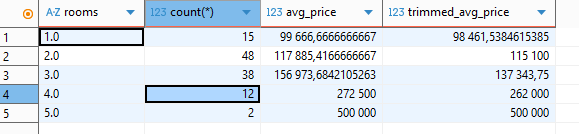

In [ ]:
WITH ranked AS (
    SELECT
        rooms,
        price,
        ROW_NUMBER() OVER (PARTITION BY rooms ORDER BY price) AS rn_asc,
        ROW_NUMBER() OVER (PARTITION BY rooms ORDER BY price DESC) AS rn_desc,
        COUNT(*) OVER (PARTITION BY rooms) AS total_count
    FROM cian_flats cf
)
SELECT
    rooms,
    count(*),
    AVG(price) AS avg_price,
    AVG(CASE
            WHEN rn_asc > total_count * 0.1
             AND rn_desc > total_count * 0.1
            THEN price
        END) AS trimmed_avg_price
FROM ranked
GROUP BY rooms
having rooms > 0
ORDER BY rooms;